In [1]:
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.integrate import quad

import h5py as h5
import arepo
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
import os
from joblib import Parallel, delayed
import warnings
from scipy.interpolate import CubicSpline

from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

import sys
sys.path.append(basepath+'note/')
import galaxy

from scipy.ndimage import gaussian_filter

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [25]:
alph = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 
        'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 
        'u', 'v', 'w', 'x', 'y', 'z', 'aa']

In [2]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

mpl.rcParams.update({'font.size': 8})

In [3]:
GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013

In [4]:
def load_galaxy(sim, sd=None, idx=320):
    if sim=='iso':
        key = 'lvl4-Ngb64'
        output_dir = basepath + 'runs/MW7iso/'+ key + '/output'
    elif sd is not None:
        key = 'lvl4-sd'+str(sd)
        output_dir = basepath + 'runs/MW7_GSE4-Rs'+sim[0]+'-Vv'+sim[1]+'-ecc'+sim[2]+'-lvl4/' + key + '/output'
    else:
        key = 'lvl4-'+'Rs'+sim[0]+'-Vv'+sim[1]+'-e'+sim[2]
        output_dir = basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output'
    return galaxy.Galaxy(output_dir, idx, orient=True)

In [5]:
allgal = {}
for Rs in tqdm(['116', '129', '142'], leave=True, position=0):
    allgal[Rs] = {}
    for Vv in ['116', '129', '142']:
        allgal[Rs][Vv] = {}
        for ecc in ['04', '05', '06']:
            sim = (Rs, Vv, ecc)
            allgal[Rs][Vv][ecc] = load_galaxy(sim)
            
allgal['iso'] = load_galaxy('iso')

100%|██████████| 3/3 [01:16<00:00, 25.58s/it]


In [6]:
allgal['rng'] = {}

sim = ('142', '116', '04')
allgal['rng'][sim[0]] = {}
allgal['rng'][sim[0]][sim[1]] = {}
allgal['rng'][sim[0]][sim[1]][sim[2]] = {}

for sd in tqdm(range(16), leave=True, position=0):
    Rs, Vv, ecc = sim
    allgal['rng'][Rs][Vv][ecc][sd] = load_galaxy(sim, sd=sd)

100%|██████████| 16/16 [02:27<00:00,  9.20s/it]


In [7]:
def extract_sim_data(gal, no_SN=False):
    sn = gal.sn
    
    ### get logFeH and logMgFe ###
    FeH = sn.part4.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = sn.part4.GFM_Metals[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH

    ### get in_SN ###
    Lzsun = 8 * 220 * 0.2
    zmax = 3
    dLz = 0.3
    
    Lz = np.cross(sn.part4.rotpos, sn.part4.rotvel)[:,2]
    in_SN = np.logical_and(np.abs((Lz/Lzsun)-1) < dLz, np.abs(sn.part4.rotpos[:,2]) < zmax)
    
    if no_SN:
        mask = np.full_like(in_SN, True)
    else:
        mask = in_SN
    
    ### get tform ###
    tform = sn.part4.GFM_StellarFormationTime
    keybool = np.logical_and(mask, tform > 0)
    
    out = {}
    out['logFeH'] = logFeH[mask]
    out['logMgFe'] = logMgFe[mask]
    out['GFM_StellarFormationTime'] = sn.part4.GFM_StellarFormationTime[mask]
    out['BirthMass'] = sn.part4.GFM_InitialMass[mask]
    # out['Pos'] = sn.part4.Coordinates[mask]
    # out['BirthPos'] = sn.part4.BirthPos[mask]
    out['in_SN'] = in_SN
    
    # load com as fn of time
    # time, com0, com1 = find_com(sd)
    # com = np.load('centering/sim_'+sim[0]+'_'+sim[1]+'_'+sim[2]+'_seed'+str(sd)+'.npy', allow_pickle=True).item()
    # out['COM'] = {}
    # for k in com.keys():
        # out['COM'][k] = com[k]
    
    return out

In [8]:
allsimdat = {}
for Rs in tqdm(['116', '129', '142'], leave=True, position=0):
    allsimdat[Rs] = {}
    for Vv in ['116', '129', '142']:
        allsimdat[Rs][Vv] = {}
        for ecc in ['04', '05', '06']:
            sim = (Rs, Vv, ecc)
            allsimdat[Rs][Vv][ecc] = extract_sim_data(allgal[Rs][Vv][ecc], no_SN=True)

allsimdat['iso'] = extract_sim_data(allgal['iso'], no_SN=True)

sim = ('142', '116', '04')
allsimdat['rng'] = {}
allsimdat['rng'][sim[0]] = {}
allsimdat['rng'][sim[0]][sim[1]] = {}
allsimdat['rng'][sim[0]][sim[1]][sim[2]] = {}

for sd in tqdm(range(16), leave=True, position=0):
    Rs, Vv, ecc = sim
    allsimdat['rng'][Rs][Vv][ecc][sd] = extract_sim_data(allgal['rng'][Rs][Vv][ecc][sd], no_SN=True)

100%|██████████| 16/16 [00:00<00:00, 37.84it/s]


In [9]:
def construct_gmm(dat, logFeH0=0, dlogFeH=0.1, no_SN=False):
    """
    Analyze peaks in the logMgFe data and determine if the data prefers 2 modes over 1 mode.

    Parameters:
        dat (dict): Dictionary containing simulated data.
        logFeH0 (float): Central logFeH value to filter data around.
        dlogFeH (float): Range of logFeH to filter data.
        no_SN (bool): If True, exclude SN filtering.

    Returns:
        preferred_gmm (GaussianMixture): The GMM model (1 or 2 modes) preferred by BIC.
        prefers_two_modes (bool): True if BIC suggests 2 modes are preferred over 1 mode.
        bic_diff (float): Difference in BIC between the 1-mode and 2-mode models.
    """
    # Extract the data
    logFeH = dat['logFeH']
    logMgFe = dat['logMgFe']
    
    if not no_SN:
        logFeH = logFeH[dat['in_SN']]
        logMgFe = logMgFe[dat['in_SN']]
    
    # Filter data based on logFeH
    key = np.logical_and(logFeH > logFeH0 - dlogFeH / 2, logFeH < logFeH0 + dlogFeH / 2)
    data = logMgFe[key].reshape(-1, 1)

    # Fit Gaussian Mixture Models with 1 and 2 components
    gmm_1 = GaussianMixture(n_components=1, random_state=0)
    gmm_2 = GaussianMixture(n_components=2, random_state=0)
    gmm_1.fit(data)
    gmm_2.fit(data)

    # Compute BIC for both models
    bic_1 = gmm_1.bic(data)
    bic_2 = gmm_2.bic(data)
    bic_diff = bic_1 - bic_2  # Positive if 2 modes are preferred

    # Determine which GMM is preferred
    prefers_two_modes = bic_diff > 0

    return gmm_1, gmm_2, prefers_two_modes, bic_diff


def calculate_overlap(mean1, std1, mean2, std2):
    """
    Calculate the overlap between two Gaussian distributions.
    
    Parameters:
        mean1, std1: Mean and standard deviation of the first Gaussian.
        mean2, std2: Mean and standard deviation of the second Gaussian.
        
    Returns:
        overlap (float): The overlap between the two distributions.
    """
    def pdf1(x):
        return norm.pdf(x, loc=mean1, scale=std1)
    
    def pdf2(x):
        return norm.pdf(x, loc=mean2, scale=std2)
    
    def min_pdf(x):
        return np.minimum(pdf1(x), pdf2(x))
    
    # Integrate the minimum of the two PDFs
    overlap, _ = quad(min_pdf, -np.inf, np.inf)
    return overlap

def bimodality_metric(gmm, t=0.1, k=20):
    """
    Calculate a bimodality metric based on the ratio of the less prominent mode's peak 
    to the trough between the two modes, adjusted by the ratio of mode weights.
    
    Parameters:
        gmm: A fitted GaussianMixture object from sklearn.
    
    Returns:
        bimodality_score (float): The calculated bimodality metric.
    """
    def weight_penalty(w2, t, k):
        return 1 / (1 + np.exp(-k * (w2 - t)))
    
    if len(gmm.means_.flatten())==1:
        return 0.0
    
    # Extract GMM parameters
    means = gmm.means_.flatten()
    variances = gmm.covariances_.flatten()
    weights = gmm.weights_

    # Ensure components are ordered by mean
    order = np.argsort(means)
    means = means[order]
    variances = variances[order]
    weights = weights[order]

    # Calculate the peaks (heights of the modes)
    peaks = weights / np.sqrt(2 * np.pi * variances)
    less_prominent_peak = min(peaks)

    # Find the trough: point between means where the GMM density is minimized
    x_trough = np.linspace(means[0], means[1], 1000)
    densities = np.exp(gmm.score_samples(x_trough.reshape(-1, 1)))
    trough_density = densities.min()

    # Compute the weight ratio (smaller weight divided by larger weight)
    # weight_ratio = min(weights) / max(weights)
    # weight_ratio = 1

    # Compute the bimodality metric, scaling by the weight ratio
    # bimodality_score = (less_prominent_peak / trough_density) * weight_ratio
    
    bimodality_score = np.abs(means[1] - means[0]) / np.sqrt(np.sum(variances))
    bimodality_score *= weight_penalty(min(weights), t, k)
    
    # bimodality_score = np.abs(means[0] - means[1])
    return bimodality_score

# Example usage:
# Assuming `simdat` is defined and contains the appropriate data
# gmm = construct_gmm(simdat[2], logFeH0=0.0, dlogFeH=0.1)
# bimodality_metric(gmm)

In [10]:
from scipy.signal import argrelextrema

def get_first_pericenter_time(sim):
    name = 'sim_'+sim[0]+'_'+sim[1]+'_'+sim[2]+'.npy'
    com = np.load('centering/'+name, allow_pickle=True).item()
    
    time = com['time']
    com0 = com['com0']
    com1 = com['com1']
    
    rdiff = np.linalg.norm(com1 - com0, axis=1)
    
    return time[argrelextrema(rdiff, np.less)[0][0]]

In [11]:
Rs_list = ['116', '129', '142']
Vv_list = ['116', '129', '142']
ecc_list = ['04', '05', '06']

bim_metric = []
ordered_sim = []
allgmm = []
tperi = []

for i,Rs in enumerate(Rs_list):
    for j,Vv in enumerate(Vv_list):
        for k,ecc in enumerate(ecc_list):
            simdat = allsimdat[Rs][Vv][ecc]
            
            _, gmm, _, _ = construct_gmm(simdat, logFeH0=0.0, dlogFeH=0.1)
            # bim_metric.append(bic_diff)
            
            bim_metric.append(bimodality_metric(gmm))
            ordered_sim.append((Rs, Vv, ecc))
            allgmm.append(gmm)
            tperi.append(get_first_pericenter_time((Rs, Vv, ecc)))

# Sorting both bim_metric and ordered_sim based on bim_metric values
sorted_data = sorted(zip(bim_metric, ordered_sim, allgmm, tperi), key=lambda x: x[0])

# Unzipping the sorted data back into separate lists
bim_metric, ordered_sim, allgmm, tperi = zip(*sorted_data)

# Converting back to lists if needed
bim_metric = list(bim_metric)
ordered_sim = list(ordered_sim)
allgmm = list(allgmm)
tperi = list(tperi)

In [26]:
for i in range(len(bim_metric)):
    print(alph[i], bim_metric[i], ordered_sim[i])

a 0.2880888530540707 ('129', '129', '04')
b 0.34998144737379205 ('129', '116', '04')
c 0.7716293661722311 ('116', '116', '04')
d 0.7939937049697606 ('142', '116', '05')
e 0.8896338540204352 ('142', '129', '06')
f 1.122393729909555 ('116', '129', '04')
g 1.248209474471725 ('116', '116', '05')
h 1.338941812590866 ('116', '142', '04')
i 1.429580009572426 ('142', '142', '05')
j 1.456608064489768 ('129', '142', '05')
k 1.617593989479247 ('142', '129', '04')
l 1.7501545529041285 ('142', '142', '06')
m 1.8219018447886826 ('116', '129', '05')
n 1.9553352812806053 ('129', '129', '05')
o 2.04065556742531 ('129', '116', '05')
p 2.1605748444154402 ('116', '116', '06')
q 2.2395535778193048 ('116', '129', '06')
r 2.2563161550897943 ('142', '129', '05')
s 2.5239067197909835 ('142', '116', '04')
t 2.5946595818152245 ('116', '142', '06')
u 2.6177317255012036 ('116', '142', '05')
v 2.6457123193530325 ('142', '116', '06')
w 2.662121415049872 ('129', '142', '06')
x 2.695414083073675 ('142', '142', '04')
y

In [20]:
sim = ('142', '116', '04')

ordered_sd = []
bim_metric_rng = []
allgmm_rng = []

for sd in tqdm(range(16), leave=True, position=0):
    Rs, Vv, ecc = sim

    ordered_sd.append(sd)
    simdat = allsimdat['rng'][Rs][Vv][ecc][sd]
            
    _, gmm, _, _ = construct_gmm(simdat, logFeH0=0.0, dlogFeH=0.1)
            
    bim_metric_rng.append(bimodality_metric(gmm))
    allgmm_rng.append(gmm)

# Sorting both bim_metric and ordered_sim based on bim_metric values
# sorted_data = sorted(zip(bim_metric, ordered_sim, allgmm, tperi), key=lambda x: x[0])
sorted_data = sorted(zip(bim_metric_rng, ordered_sd, allgmm_rng), key=lambda x: x[0])

# Unzipping the sorted data back into separate lists
# bim_metric, ordered_sim, allgmm, tperi = zip(*sorted_data)
bim_metric_rng, ordered_sd, allgmm_rng = zip(*sorted_data)

# Converting back to lists if needed
bim_metric_rng = list(bim_metric_rng)
ordered_sd = list(ordered_sd)
allgmm_rng = list(allgmm_rng)
# tperi = list(tperi)

100%|██████████| 16/16 [00:00<00:00, 72.93it/s]


In [21]:
# for i in range(27):
for i in range(16):
    # print(round(bim_metric[i], 3), ordered_sim[i], min(allgmm[i].weights_))
    print(round(bim_metric_rng[i], 3), ordered_sd[i], min(allgmm_rng[i].weights_))
    # if ordered_sim[i][2] != '04':
        # continue
    # print(round(bim_metric[i], 3), ordered_sim[i], tperi[i])

1.072 2 0.12737516176854888
1.101 3 0.11484821795773378
1.242 15 0.13884987954096364
1.354 1 0.1486253249319677
1.578 8 0.16994715735498261
1.732 11 0.16676686810992827
1.873 5 0.10907549987104473
1.894 10 0.14500421544550887
2.034 9 0.14183086204813056
2.041 6 0.18299081255038002
2.524 0 0.19564699166530278
2.604 7 0.20841925829370173
2.671 12 0.1947237714899063
2.791 4 0.22703692740923911
2.817 14 0.24852105017610734
3.405 13 0.25676347652884474


2 0 2


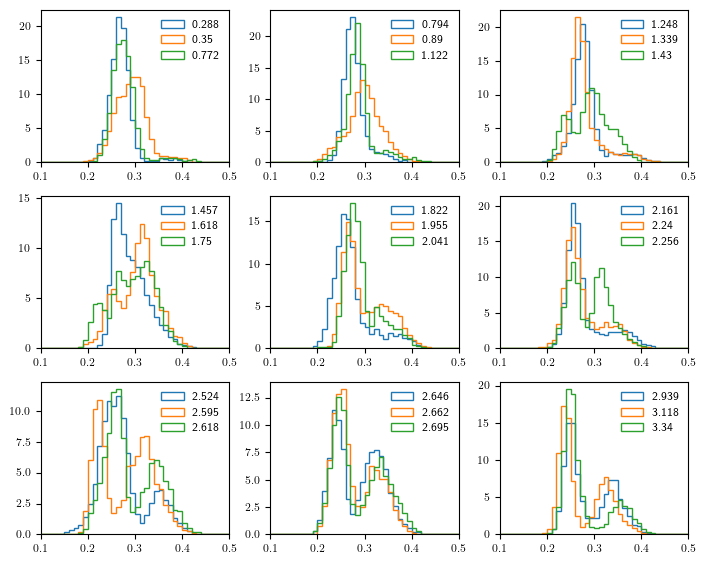

In [14]:
fig, axs = plt.subplots(3, 3, figsize=(textwidth, 0.8 * textwidth))

logFeH0 = 0
dlogFeH = 0.1
bins = np.arange(0.1, 0.5 + 0.01, 0.01)

# Iterate over 3x3 panels
for i in range(3):
    for j in range(3):
        ax = axs[i][j]
        
        # Determine the range of indices for the current panel
        start_idx = (i * 3 + j) * 3
        end_idx = start_idx + 3
        
        # Fetch the corresponding 3 lowest bim_metric and their associated parameters
        panel_bim_metrics = bim_metric[start_idx:end_idx]
        panel_sim_params = ordered_sim[start_idx:end_idx]
        
        for bim, (Rs, Vv, ecc) in zip(panel_bim_metrics, panel_sim_params):
            # Access the simulation data
            simdat = allsimdat[Rs][Vv][ecc]
            
            if Rs=='142' and Vv=='116' and ecc=='04':
                print(i, j, k)
            
            # Construct GMM and compute logFeH and logMgFe
            logFeH = simdat['logFeH']
            logMgFe = simdat['logMgFe']
            mask = np.logical_and(
                logFeH > logFeH0 - dlogFeH / 2.0,
                logFeH < logFeH0 + dlogFeH / 2.0,
            )
            mask = np.logical_and(mask, simdat['in_SN'])
            
            # Plot histogram
            # ax.hist(logMgFe[mask], bins=bins, histtype='step', density=True, label=f"Rs={Rs}, Vv={Vv}, ecc={ecc}")
            ax.hist(logMgFe[mask], bins=bins, histtype='step', density=True, label=str(round(bim, 3)))
        
        ax.set(xlim=(0.1, 0.5))
        ax.legend(frameon=False)

fig.tight_layout()


# MgFe_dist

In [15]:
fig, axs = plt.subplots(3, 3, figsize=(textwidth, 0.8 * textwidth), sharex=True, sharey=True)

logFeH0 = 0
dlogFeH = 0.1
bins = np.arange(0.1, 0.5 + 0.01, 0.01)

# Iterate over 3x3 panels
for i in range(3):
    for j in range(3):
        ax = axs[i][j]
        
        # Determine the range of indices for the current panel
        start_idx = (i * 3 + j) * 3
        end_idx = start_idx + 3
        
        # Fetch the corresponding 3 lowest bim_metric and their associated parameters
        panel_bim_metrics = bim_metric[start_idx:end_idx]
        panel_sim_params = ordered_sim[start_idx:end_idx]
        
        for bim, (Rs, Vv, ecc), c in zip(panel_bim_metrics, panel_sim_params, tb_c):
            # Access the simulation data
            simdat = allsimdat[Rs][Vv][ecc]
            
            if Rs=='142' and Vv=='116' and ecc=='04':
                print(i, j, k)
            
            # Construct GMM and compute logFeH and logMgFe
            logFeH = simdat['logFeH']
            logMgFe = simdat['logMgFe']
            mask = np.logical_and(
                logFeH > logFeH0 - dlogFeH / 2.0,
                logFeH < logFeH0 + dlogFeH / 2.0,
            )
            mask = np.logical_and(mask, simdat['in_SN'])
            # mask[:] = True
            
            # Plot histogram
            # ax.hist(logMgFe[mask], bins=bins, histtype='step', density=True, label=f"Rs={Rs}, Vv={Vv}, ecc={ecc}")
            # ax.hist(logMgFe[mask], bins=bins, histtype='step', density=True, label=str(round(bim, 3)), color=c)
            
            counts, bin_edges = np.histogram(logMgFe[mask], bins=bins, density=True)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            # Plot histogram as a line
            label = f"Rs={Rs}, Vv={Vv}, ecc={ecc}"
            # label = r'$'+str(round(bim, 3))+r'$'
            ax.plot(bin_centers, counts, c=c, label=label)
        
        ax.legend(frameon=False)

axs[0][0].set(xlim=(0.1, 0.5), ylim=(0, 27.5))

for x in axs[2]:
    x.set(xlabel=r'$[\textrm{Mg}/\textrm{Fe}]$')

fig.tight_layout()
fig.savefig('MgFe_dist.pdf')
plt.close(fig)


2 0 2


NameError: name 'bim_metric_rng' is not defined

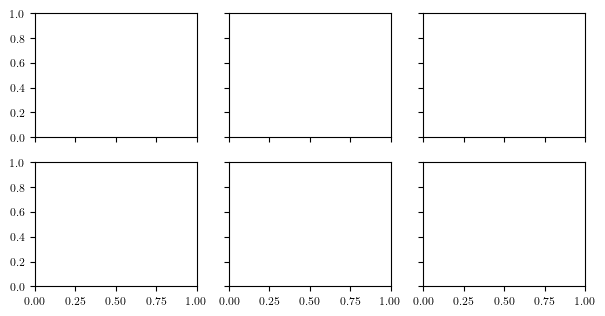

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(textwidth, 0.5 * textwidth), sharex=True, sharey=True)

logFeH0 = 0
dlogFeH = 0.1
bins = np.arange(0.1, 0.5 + 0.01, 0.01)

sim = ('142', '116', '04')

# Iterate over 3x3 panels
for i in range(2):
    for j in range(3):
        ax = axs[i][j]
        
        # Determine the range of indices for the current panel
        start_idx = (i * 2 + j) * 3
        end_idx = start_idx + 2
        
        # Fetch the corresponding 3 lowest bim_metric and their associated parameters
        panel_bim_metrics = bim_metric_rng[start_idx:end_idx]
        panel_sd_params = ordered_sd[start_idx:end_idx]
        
        for bim, sd, c in zip(panel_bim_metrics, panel_sd_params, tb_c):
            # Access the simulation data
            Rs, Vv, ecc = sim
            simdat = allsimdat['rng'][Rs][Vv][ecc][sd]
            
            # if Rs=='142' and Vv=='116' and ecc=='04':
                # print(i, j, k)
            
            # Construct GMM and compute logFeH and logMgFe
            logFeH = simdat['logFeH']
            logMgFe = simdat['logMgFe']
            mask = np.logical_and(
                logFeH > logFeH0 - dlogFeH / 2.0,
                logFeH < logFeH0 + dlogFeH / 2.0,
            )
            mask = np.logical_and(mask, simdat['in_SN'])
            # mask[:] = True
            
            # Plot histogram
            # ax.hist(logMgFe[mask], bins=bins, histtype='step', density=True, label=f"Rs={Rs}, Vv={Vv}, ecc={ecc}")
            # ax.hist(logMgFe[mask], bins=bins, histtype='step', density=True, label=str(round(bim, 3)), color=c)
            
            counts, bin_edges = np.histogram(logMgFe[mask], bins=bins, density=True)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            # Plot histogram as a line
            label = f"Rs={Rs}, Vv={Vv}, ecc={ecc}"
            # label = r'$'+str(round(bim, 3))+r'$'
            ax.plot(bin_centers, counts, c=c, label=label)
        
        ax.legend(frameon=False)

axs[0][0].set(xlim=(0.1, 0.5), ylim=(0, 27.5))

for x in axs[1]:
    x.set(xlabel=r'$[\textrm{Mg}/\textrm{Fe}]$')

fig.tight_layout()
fig.savefig('MgFe_dist_rng.pdf')
plt.close(fig)


# sfh_atfe

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(textwidth, 0.8 * textwidth))

logFeH0 = 0
dlogFeH = 0.1
bins = np.arange(0, 8 + 0.1, 0.1)

sim0 = ('129', '116', '05')
sim1 = ('116', '142', '05')

def is_same_sim(sim0, sim1):
    if sim0[0] == sim1[0]:
        if sim0[1] == sim1[1]:
            if sim0[2] == sim1[2]:
                return True
    
    return False

# Iterate over 3x3 panels
for i in range(3):
    for j in range(3):
        ax = axs[i][j]
        
        # Determine the range of indices for the current panel
        start_idx = (i * 3 + j) * 3
        end_idx = start_idx + 3
        
        # Fetch the corresponding 3 lowest bim_metric and their associated parameters
        panel_bim_metrics = bim_metric[start_idx:end_idx]
        panel_sim_params = ordered_sim[start_idx:end_idx]
        
        for bim, (Rs, Vv, ecc), c in zip(panel_bim_metrics, panel_sim_params, tb_c):
            # Access the simulation data
            simdat = allsimdat[Rs][Vv][ecc]
            
            # Construct GMM and compute logFeH and logMgFe
            logFeH = simdat['logFeH']
            logMgFe = simdat['logMgFe']
            tform = simdat['GFM_StellarFormationTime']
            mask = np.logical_and(
                logFeH > logFeH0 - dlogFeH / 2.0,
                logFeH < logFeH0 + dlogFeH / 2.0,
            )
            mask = np.logical_and(mask, simdat['in_SN'])
            # mask[:] = True
            mask = simdat['in_SN']
            
            # Compute histogram
            counts, bin_edges = np.histogram(tform[mask], bins=bins, density=True)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            # Plot histogram as a line
            ax.plot(bin_centers, counts, label=f"Rs={Rs}, Vv={Vv}, ecc={ecc}", c=c)

            if is_same_sim(sim0, (Rs, Vv, ecc)) or is_same_sim(sim1, (Rs, Vv, ecc)):
                tkey = np.logical_and(bin_centers > 2, bin_centers < 3.5)
                print((Rs, Vv, ecc), bin_centers[np.argmin(counts[tkey])])
            
        ax.set(xlim=(0, 5), ylim=(0, 0.6))
        ax.axhline(0.1, c='k', ls='dashed')
        # ax.legend(fontsize=8, frameon=False)

fig.tight_layout()
fig.savefig('sfh.pdf')
# plt.close(fig)


In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(textwidth, 0.8 * textwidth))

logFeH0 = 0
dlogFeH = 0.1
bins = np.arange(0, 8 + 0.1, 0.1)

sim0 = ('129', '116', '05')
sim1 = ('116', '142', '05')

def is_same_sim(sim0, sim1):
    if sim0[0] == sim1[0]:
        if sim0[1] == sim1[1]:
            if sim0[2] == sim1[2]:
                return True
    
    return False

# Iterate over 3x3 panels
for i in range(3):
    for j in range(3):
        ax = axs[i][j]
        
        # Determine the range of indices for the current panel
        start_idx = (i * 3 + j) * 3
        end_idx = start_idx + 3
        
        # Fetch the corresponding 3 lowest bim_metric and their associated parameters
        panel_bim_metrics = bim_metric[start_idx:end_idx]
        panel_sim_params = ordered_sim[start_idx:end_idx]
        
        for bim, (Rs, Vv, ecc), c in zip(panel_bim_metrics, panel_sim_params, tb_c):
            # Access the simulation data
            simdat = allsimdat[Rs][Vv][ecc]
            
            # Construct GMM and compute logFeH and logMgFe
            logFeH = simdat['logFeH']
            logMgFe = simdat['logMgFe']
            tform = simdat['GFM_StellarFormationTime']
            mask = np.logical_and(
                logFeH > logFeH0 - dlogFeH / 2.0,
                logFeH < logFeH0 + dlogFeH / 2.0,
            )
            mask = np.logical_and(mask, simdat['in_SN'])
            # mask[:] = True
            
            # Compute histogram
            counts, bin_edges = np.histogram(tform[mask], bins=bins, density=True)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            # Plot histogram as a line
            ax.plot(bin_centers, counts, label=f"Rs={Rs}, Vv={Vv}, ecc={ecc}", c=c)

            if is_same_sim(sim0, (Rs, Vv, ecc)) or is_same_sim(sim1, (Rs, Vv, ecc)):
                tkey = np.logical_and(bin_centers > 2, bin_centers < 3.5)
                print((Rs, Vv, ecc), bin_centers[np.argmin(counts[tkey])])
            
        ax.set(xlim=(0, 5), ylim=(0, 1))
        ax.axhline(0.1, c='k', ls='dashed')
        # ax.legend(fontsize=8, frameon=False)

fig.tight_layout()
fig.savefig('sfh_atfe.pdf')
# plt.close(fig)


In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(textwidth, 0.5 * textwidth))

logFeH0 = 0
dlogFeH = 0.1
bins = np.arange(0, 8 + 0.1, 0.1)

# Iterate over 3x3 panels
for i in range(2):
    for j in range(3):
        ax = axs[i][j]
        
        # Determine the range of indices for the current panel
        start_idx = (i * 2 + j) * 3
        end_idx = start_idx + 2
        
        sim = ('142', '116', '04')
        
        # Fetch the corresponding 3 lowest bim_metric and their associated parameters
        panel_bim_metrics = bim_metric_rng[start_idx:end_idx]
        panel_sd_params = ordered_sd[start_idx:end_idx]
        
        for bim, sd, c in zip(panel_bim_metrics, panel_sd_params, tb_c):
            # Access the simulation data
            Rs, Vv, ecc = sim
            simdat = allsimdat['rng'][Rs][Vv][ecc][sd]
            
            # Construct GMM and compute logFeH and logMgFe
            logFeH = simdat['logFeH']
            logMgFe = simdat['logMgFe']
            tform = simdat['GFM_StellarFormationTime']
            mask = np.logical_and(
                logFeH > logFeH0 - dlogFeH / 2.0,
                logFeH < logFeH0 + dlogFeH / 2.0,
            )
            mask = np.logical_and(mask, simdat['in_SN'])
            # mask[:] = True
            
            # Compute histogram
            counts, bin_edges = np.histogram(tform[mask], bins=bins, density=True)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            # Plot histogram as a line
            ax.plot(bin_centers, counts, label=f"Rs={Rs}, Vv={Vv}, ecc={ecc}", c=c)
        
        ax.set(xlim=(0, 5), ylim=(0, 1))
        ax.axhline(0.1, c='k', ls='dashed')
        # ax.legend(fontsize=8, frameon=False)

fig.tight_layout()
fig.savefig('sfh_atfe_rng.pdf')
# plt.close(fig)


In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(textwidth, 0.8 * textwidth), sharex=True)

logFeH0 = 0
dlogFeH = 0.1
bins = np.arange(0, 8 + 0.1, 0.1)

# Iterate over 3x3 panels
for i in range(3):
    for j in range(3):
        ax = axs[i][j]
        
        # Determine the range of indices for the current panel
        start_idx = (i * 3 + j) * 3
        end_idx = start_idx + 3
        
        # Fetch the corresponding 3 lowest bim_metric and their associated parameters
        panel_bim_metrics = bim_metric[start_idx:end_idx]
        panel_sim_params = ordered_sim[start_idx:end_idx]
        
        offset = 0
        doffset = -0.3
        for bim, (Rs, Vv, ecc), c in zip(panel_bim_metrics, panel_sim_params, tb_c):
            # Access the simulation data
            simdat = allsimdat[Rs][Vv][ecc]
            logFeH = simdat['logFeH']
            logMgFe = simdat['logMgFe']
            tform = simdat['GFM_StellarFormationTime']
            
            mask = np.logical_and(logFeH > logFeH0 - dlogFeH/2, 
                                  logFeH < logFeH0 + dlogFeH/2)
            mask = np.logical_and(mask, simdat['in_SN'])
            
            mask = np.where(mask)[0]
            mask = np.random.choice(mask, int(0.1*len(mask)+0.5))
            
            ax.scatter(tform[mask], logMgFe[mask]+offset,
                       c=c, s=0.4, alpha=0.5, label=f"Rs={Rs}, Vv={Vv}, ecc={ecc}")
        
            offset += doffset
            
        ax.set(xlim=(0, 5), ylim=(-0.5, 0.5))
        if i == 2:
            ax.text(0.15, 0.36, r'$\textrm{\underline{blue}}$', c=tb_c[0])
            ax.text(0.15, 0.15, r'$\textrm{\underline{orange}}$', c=tb_c[1])
            ax.text(0.15, -0.2, r'$\textrm{\underline{red}}$', c=tb_c[2])
        elif i == 1 and j == 2:
            ax.text(0.15, 0.36, r'$\textrm{blue}$', c=tb_c[0])
            ax.text(0.15, 0.15, r'$\textrm{orange}$', c=tb_c[1])
            ax.text(0.15, -0.2, r'$\textrm{\underline{red}}$', c=tb_c[2])
        else:
            ax.text(0.15, 0.36, r'$\textrm{blue}$', c=tb_c[0])
            ax.text(0.15, 0.15, r'$\textrm{orange}$', c=tb_c[1])
            ax.text(0.15, -0.2, r'$\textrm{red}$', c=tb_c[2])
        
        # ax.legend(fontsize=8, frameon=False)

for ax in axs[2]:
    ax.set(xlabel=r'$\textrm{time}\,[\,\textrm{Gyr}\,]$')
    
for ax in axs[:,0]:
    ax.set(ylabel=r'$[\textrm{Mg}/\textrm{Fe}] + \textrm{ offset}$')
    
for ax in axs.ravel():
    ax.set(title=r'$\longrightarrow$')

axs[0][0].set(title=r'$\textrm{least bimodal}$')
axs[2][2].set(title=r'$\textrm{most bimodal}$')

fig.tight_layout()
fig.savefig('alpha_tform.pdf')
# plt.close(fig)
print('done!')

# tot metals

In [ ]:
def get_tot_metals(sim, idx=320):
    key = 'lvl4-'+'Rs'+sim[0]+'-Vv'+sim[1]+'-e'+sim[2]
    output_dir = basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output/'
    snapname = output_dir + 'snapshot_' + str(idx).zfill(3) + '.hdf5'
    snaph5 = h5.File(snapname, mode='r')
    
    NumPart_Total = snaph5['Header'].attrs['NumPart_Total']
    Time = snaph5['Header'].attrs['Time']
    
    totFe  = 0.0
    totMg  = 0.0
    totmass = 0.0
    
    for pt in [0, 4]:
        if NumPart_Total[pt] == 0:
            continue
        
        ptype = 'PartType'+str(pt)
    
        GFM_Metals = snaph5[ptype]['GFM_Metals'][:]
        Masses = snaph5[ptype]['Masses'][:]
    
        totFe += np.sum(GFM_Metals[:,8]*Masses)
        totMg += np.sum(GFM_Metals[:,6]*Masses)
        totmass += np.sum(Masses)
        
    if NumPart_Total[5] > 0:
        MBH = np.max(snaph5['PartType5']['Masses'])
    else:
        MBH = 0
    
    snaph5.close()
    
    return Time, totFe, totMg, totmass, MBH
    

In [ ]:
def get_allout(sim, nsnap=200):
    # itr = tqdm(range(nsnap+1), leave=True, position=0
    itr = range(nsnap+1)
    outs = Parallel(n_jobs=24) (delayed(get_tot_metals)(sim, idx) for idx in itr)

    allout = {}
    
    allout['Time']    = np.array([o[0] for o in outs])
    allout['totFe']  = np.array([o[1] for o in outs])
    allout['totMg']  = np.array([o[2] for o in outs])
    allout['totmass'] = np.array([o[3] for o in outs])
    allout['MBH']     = np.array([o[4] for o in outs])
    
    return allout

In [ ]:
allouts = {}
for Rs in tqdm(['116', '129', '142'], leave=True, position=0):
    allouts[Rs] = {}
    for Vv in ['116', '129', '142']:
        allouts[Rs][Vv] = {}
        for ecc in ['04', '05', '06']:
            sim = (Rs, Vv, ecc)
            allouts[Rs][Vv][ecc] = get_allout(sim)

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(textwidth, 0.8 * textwidth))

logFeH0 = 0
dlogFeH = 0.1
bins = np.arange(0, 8 + 0.1, 0.1)

# Iterate over 3x3 panels
for i in range(3):
    for j in range(3):
        ax = axs[i][j]
        
        # Determine the range of indices for the current panel
        start_idx = (i * 3 + j) * 3
        end_idx = start_idx + 3
        
        # Fetch the corresponding 3 lowest bim_metric and their associated parameters
        panel_bim_metrics = bim_metric[start_idx:end_idx]
        panel_sim_params = ordered_sim[start_idx:end_idx]
        
        for bim, (Rs, Vv, ecc), c in zip(panel_bim_metrics, panel_sim_params, tb_c):
            # Access the simulation data
            allout = allouts[Rs][Vv][ecc]
            
            # Construct GMM and compute logFeH and logMgFe
            Time = allout['Time']
            totFe = allout['totFe']
            totMg = allout['totMg']
            dFedt = np.gradient(totFe, Time)
            dMgdt = np.gradient(totMg, Time)
            
            # label = f"Rs={Rs}, Vv={Vv}, ecc={ecc}"
            label = r'$'+str(round(bim, 3))+r'$'
            
            ax.plot(Time, dFedt/dMgdt, label=label, c=c)
            
        ax.set(xlim=(0, 5), ylim=(0, 3))
        # ax.axhline(0.1, c='k', ls='dashed')
        # ax.legend(fontsize=8, frameon=False)

fig.tight_layout()
# fig.savefig('allsfh.pdf')
# plt.close(fig)

# build up of kind of bimodal

In [24]:
allsimdat['142']['116']['06']

{'logFeH': array([ 0.38379875,  0.32216957, -0.26648122, ..., -5.4811378 ,
        -5.533228  ,  0.38063034], dtype=float32),
 'logMgFe': array([0.34569255, 0.27639136, 0.39008617, ..., 1.0211024 , 0.66628027,
        0.2846615 ], dtype=float32),
 'GFM_StellarFormationTime': array([2.1597595 , 2.9174805 , 1.5864258 , ..., 0.3330078 , 0.49121094,
        3.230957  ], dtype=float32),
 'BirthMass': Quantity([9.83553605e-06, 7.16779037e-06, 7.79230522e-06, ...,
           1.00794931e-05, 7.01358254e-06, 9.95165652e-06], unit=[1e+10 Msol]),
 'in_SN': array([False, False, False, ..., False, False, False])}

0.826171875
0.9248101033149385
0.67578125
1.0651062430564449


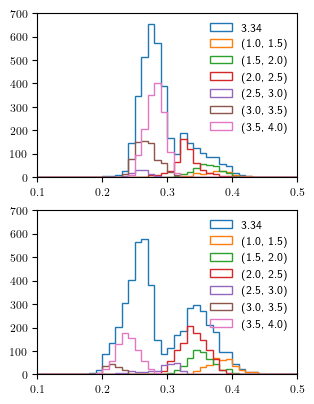

In [25]:
def matchsim(sim):
    for i in range(len(ordered_sim)):
        if sim[0] == ordered_sim[i][0]:
            if sim[1] == ordered_sim[i][1]:
                if sim[2] == ordered_sim[i][2]:
                    return i

def plot_panel(sim, fig, ax, t0=1):
    logFeH0 = 0
    dlogFeH = 0.1
    bins = np.arange(0.1, 0.5 + 0.01, 0.01)

    Rs, Vv, ecc = sim
    idx = matchsim(sim)
    simdat = allsimdat[Rs][Vv][ecc]
    print(tperi[idx])
    
    
    logFeH = simdat['logFeH']
    logMgFe = simdat['logMgFe']
    tform = simdat['GFM_StellarFormationTime']
    initmass = simdat['BirthMass']
    mask = np.logical_and(
        logFeH > logFeH0 - dlogFeH / 2.0,
        logFeH < logFeH0 + dlogFeH / 2.0,
    )
    mask = np.logical_and(mask, simdat['in_SN'])
    
    print(np.sum(initmass[tform < t0]))
            
    # Plot histogram
    # ax.hist(logMgFe[mask], bins=bins, histtype='step', density=True, label=f"Rs={Rs}, Vv={Vv}, ecc={ecc}")
    ax.hist(logMgFe[mask], bins=bins, histtype='step', label=str(round(bim, 3)))
    ax.set(xlim=(0.1, 0.5))

    tbin = np.arange(1, 4+0.5, 0.5)
    for i in range(len(tbin)-1):
        tmask = np.logical_and(tform > tbin[i], tform < tbin[i+1])
        tmask = np.logical_and(tmask, mask)
    
        ax.hist(logMgFe[tmask], bins=bins, histtype='step', label='('+str(round(tbin[i], 2)) + ', ' + str(round(tbin[i+1], 2)) +')')

    ax.legend(frameon=False)
    ax.set(ylim=(0, 700))
        
fig, axs = plt.subplots(2, 1, figsize=(columnwidth, 1.4 * columnwidth))

plot_panel(('129', '116', '05'), fig, axs[0], t0=2.5)
plot_panel(('116', '142', '05'), fig, axs[1], t0=3)



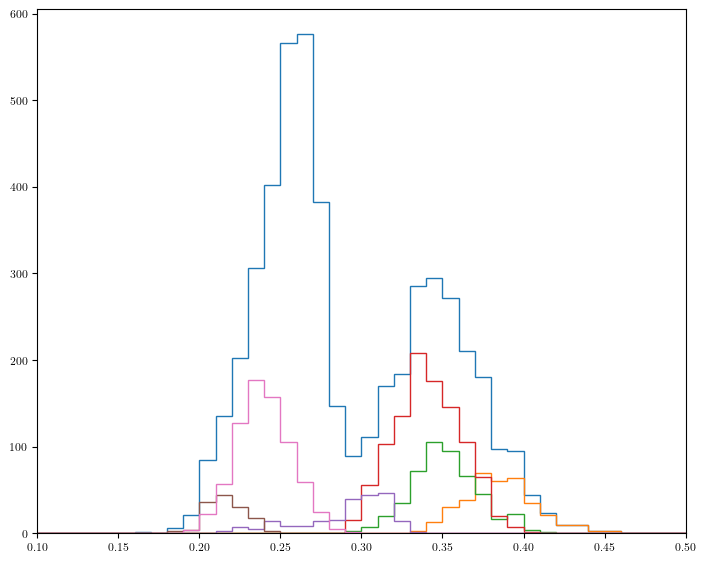

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(textwidth, 0.8 * textwidth))

logFeH0 = 0
dlogFeH = 0.1
bins = np.arange(0.1, 0.5 + 0.01, 0.01)

sim = ('116', '142', '05')
Rs, Vv, ecc = sim
simdat = allsimdat[Rs][Vv][ecc]

logFeH = simdat['logFeH']
logMgFe = simdat['logMgFe']
tform = simdat['GFM_StellarFormationTime']
mask = np.logical_and(
    logFeH > logFeH0 - dlogFeH / 2.0,
    logFeH < logFeH0 + dlogFeH / 2.0,
)
mask = np.logical_and(mask, simdat['in_SN'])
            
# Plot histogram
# ax.hist(logMgFe[mask], bins=bins, histtype='step', density=True, label=f"Rs={Rs}, Vv={Vv}, ecc={ecc}")
ax.hist(logMgFe[mask], bins=bins, histtype='step', label=str(round(bim, 3)))
ax.set(xlim=(0.1, 0.5))

tbin = np.arange(1, 4+0.5, 0.5)
for i in range(len(tbin)-1):
    tmask = np.logical_and(tform > tbin[i], tform < tbin[i+1])
    tmask = np.logical_and(tmask, mask)
    
    ax.hist(logMgFe[tmask], bins=bins, histtype='step')

fig.tight_layout()


# alpha as fn of time

In [17]:
def get_gaussian_fit(simdat, dt=0.2, logFeH0 = 0, dlogFeH = 0.1):
    tform   = simdat['GFM_StellarFormationTime']
    logMgFe = simdat['logMgFe']
    logFeH  = simdat['logFeH']
    
    mask = np.logical_and(logFeH > logFeH0 - dlogFeH/2., logFeH < logFeH0 + dlogFeH/2.)
    mask = np.logical_and(mask, simdat['in_SN'])
    
    tbins = np.arange(0, 8+dt, dt)
    tcen = 0.5 * (tbins[1:] + tbins[:-1])
    
    mu_list = []
    sigma_list = []
    amp_list = []
    
    for t0 in tbins[:-1]:
        mask_att0 = np.logical_and(tform > t0, tform < t0 + dt)
        mask_att0 = np.logical_and(mask, mask_att0)
        
        amp = np.sum(mask_att0)
        if amp > 10:
            mu, sigma = norm.fit(logMgFe[mask_att0])
        else:
            mu, sigma = np.nan, np.nan
        
        mu_list.append(mu)
        sigma_list.append(sigma)
        amp_list.append(amp)
    
    out = {}
    out['tcen'] = np.array(tcen)
    out['tbins'] = np.array(tbins)
    out['mu'] = np.array(mu_list)
    out['sigma'] = np.array(sigma_list)
    out['amp'] = np.array(amp_list)
    
    return out

In [18]:
allgaussfit = {}
for Rs in tqdm(['116', '129', '142'], leave=True, position=0):
    allgaussfit[Rs] = {}
    for Vv in ['116', '129', '142']:
        allgaussfit[Rs][Vv] = {}
        for ecc in ['04', '05', '06']:
            sim = (Rs, Vv, ecc)
            allgaussfit[Rs][Vv][ecc] = get_gaussian_fit(allsimdat[Rs][Vv][ecc])

allgaussfit['iso'] = get_gaussian_fit(allsimdat['iso'])

100%|██████████| 3/3 [00:00<00:00,  5.60it/s]


In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(textwidth, 0.8 * textwidth), sharex=True)

logFeH0 = 0
dlogFeH = 0.1
bins = np.arange(0, 8 + 0.1, 0.1)

# Iterate over 3x3 panels
for i in range(3):
    for j in range(3):
        ax = axs[i][j]
        
        # Determine the range of indices for the current panel
        start_idx = (i * 3 + j) * 3
        end_idx = start_idx + 3
        
        # Fetch the corresponding 3 lowest bim_metric and their associated parameters
        panel_bim_metrics = bim_metric[start_idx:end_idx]
        panel_sim_params = ordered_sim[start_idx:end_idx]
        
        offset = 0.
        doffset = -0.2
        for bim, (Rs, Vv, ecc), c in zip(panel_bim_metrics, panel_sim_params, tb_c):
            # Access the simulation data
            gfit = allgaussfit[Rs][Vv][ecc]
            # ax.plot(gfit['tcen'], gfit['mu'], c=c)

            tbins = gfit['tbins']
            tcen = gfit['tcen']
            amp_norm = gfit['amp'] / np.max(gfit['amp'][tcen < 5])
            amp_norm[amp_norm>1] = 1
            mu_plus_sigma  = gfit['mu'] + gfit['sigma'] + offset
            mu_minus_sigma = gfit['mu'] - gfit['sigma'] + offset

            for k in range(len(tbins) - 1):
                ax.fill_between(
                    tbins[k:k+2], 
                    mu_minus_sigma[k:k+1], 
                    mu_plus_sigma[k:k+1], 
                    color=c, 
                    alpha=amp_norm[k]
                )
            
                ax.set(xlim=(0, 5), ylim=(0.15-0.4, 0.5))
            
            offset += doffset
        
        ax.text(0.5, 0.35, r'$\textrm{\textbf{'+alph[start_idx]+r'}}$', c=tb_c[0], ha='center')
        ax.text(0.5, 0.35+doffset, r'$\textrm{\textbf{'+alph[start_idx+1]+r'}}$', c=tb_c[1], ha='center')
        ax.text(0.5, 0.35+2*doffset, r'$\textrm{\textbf{'+alph[start_idx+2]+r'}}$', c=tb_c[2], ha='center')
            
        # if i == 2:
            # ax.text(0.15, 0.36, r'$\textrm{\underline{blue}}$', c=tb_c[0])
            # ax.text(0.15, 0.15, r'$\textrm{\underline{orange}}$', c=tb_c[1])
            # ax.text(0.15, -0.2, r'$\textrm{\underline{red}}$', c=tb_c[2])
        # elif i == 1 and j == 2:
            # ax.text(0.15, 0.36, r'$\textrm{blue}$', c=tb_c[0])
            # ax.text(0.15, 0.15, r'$\textrm{orange}$', c=tb_c[1])
            # ax.text(0.15, -0.2, r'$\textrm{\underline{red}}$', c=tb_c[2])
        # else:
            # ax.text(0.15, 0.36, r'$\textrm{blue}$', c=tb_c[0])
            # ax.text(0.15, 0.15, r'$\textrm{orange}$', c=tb_c[1])
            # ax.text(0.15, -0.2, r'$\textrm{red}$', c=tb_c[2])
        
        # ax.legend(fontsize=8, frameon=False)

for ax in axs[2]:
    ax.set(xlabel=r'$\textrm{time}\,[\,\textrm{Gyr}\,]$')

for ax in axs[:,0]:
    ax.set(ylabel=r'$[\textrm{Mg}/\textrm{Fe}]+\textrm{offset}$')
    
# for ax in axs[:,0]:
    # ax.set(ylabel=r'$[\textrm{Mg}/\textrm{Fe}] + \textrm{ offset}$')
    
for ax in axs.ravel():
    ax.set(title=r'$\longrightarrow$')

axs[0][0].set(title=r'$\textrm{least bimodal}$')
axs[2][2].set(title=r'$\textrm{most bimodal}$')

fig.tight_layout()
fig.savefig('gauss_fit.pdf')
# plt.close(fig)
print('done!')

In [39]:
time[2:2+2]

array([0.5, 0.7])

# bimodality metric applied to APOGEE

In [34]:
def extract_obs_data(hdul):
    # first do quality cuts
    no_starflag = hdul[1].data.STARFLAG == 0
    good_snr = hdul[1].data.SNR > 200
    good_vscatter = hdul[1].data.VSCATTER < 1
    good_parallax = hdul[1].data.GAIAEDR3_PARALLAX/hdul[1].data.GAIAEDR3_PARALLAX_ERROR > 1
    good_logg = np.logical_and(hdul[1].data.LOGG < 3.5, hdul[1].data.LOGG_ERR < 0.2)
    
    aspcap_keys = np.logical_and(no_starflag, good_snr)
    aspcap_keys = np.logical_and(aspcap_keys, good_vscatter)
    aspcap_keys = np.logical_and(aspcap_keys, good_parallax)
    aspcap_keys = np.logical_and(aspcap_keys, good_logg)
    
    # now get SN stars based on Lz
    ra = hdul[1].data.RA * u.degree
    dec = hdul[1].data.DEC * u.degree
    distance = (hdul[1].data.GAIAEDR3_PARALLAX*u.mas).to(u.pc, u.parallax())
    pm_ra = hdul[1].data.GAIAEDR3_PMRA * u.mas/u.yr
    pm_dec = hdul[1].data.GAIAEDR3_PMDEC * u.mas/u.yr
    radial_velocity=hdul[1].data.GAIAEDR3_DR2_RADIAL_VELOCITY * u.km/u.s
    
    cosdec = np.cos(hdul[1].data.DEC * np.pi/180)
    pm_ra_cosdec = pm_ra
    
    c1 = coord.SkyCoord(ra=ra, dec=dec,
                    distance=distance,
                    pm_ra_cosdec=pm_ra_cosdec,
                    pm_dec=pm_dec,
                    radial_velocity=radial_velocity,
                    frame='icrs')
    
    gc1 = c1.transform_to(coord.Galactocentric)
    
    Lz = gc1.x * gc1.v_y - gc1.y * gc1.v_x
    Lz = Lz.to(u.kpc*u.km/u.s).value
    Lzsun = -8 * 220
    key = np.abs(Lz/Lzsun - 1) < 0.1
    
    in_SN = np.logical_and(key, aspcap_keys)
    
    logFeH = hdul[1].data.FE_H
    logMgFe = hdul[1].data.MG_FE

    out = {}
    out['logFeH'] = logFeH[in_SN]
    out['logMgFe'] = logMgFe[in_SN]
    
    return out

In [39]:
hdul = fits.open('../../data/allStar-dr17-synspec_rev1.fits')
obsdata = extract_obs_data(hdul)

In [51]:
gmm = construct_gmm(obsdata, logFeH0=-0.4, dlogFeH=0.1, no_SN=True)
bimodality_metric(gmm)

5.143143965937522

# check SFE as fn of time

In [110]:
def get_summary(idx, sim, rmin=2, rmax=np.inf, rgal=15):
    out = {}
    key = 'lvl4-Rs'+sim[0]+'-Vv'+sim[1]+'-e'+sim[2]
    output_dir = basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output'
    
    com = np.load('centering/sim_'+sim[0]+'_'+sim[1]+'_'+sim[2]+'.npy', allow_pickle=True).item()
    com0 = com['com0'][idx]
    
    subfname = output_dir + '/fof_subhalo_tab_'+str(idx).zfill(3)+'.hdf5'
    if not os.path.exists(subfname):
        return out
    
    snap = h5.File(output_dir + '/snapshot_'+str(idx).zfill(3)+'.hdf5', mode='r')
    NumPart_Total = snap['Header'].attrs['NumPart_Total']
    Time = snap['Header'].attrs['Time']
    out['Time'] = Time
    
    pos0 = snap['PartType0/Coordinates'][:]
    r0 = np.linalg.norm(pos0 - com0, axis=1)
    mask = np.logical_and(r0 > rmin, r0 < rmax)
    
    mass0 = snap['PartType0/Masses'][:][mask]
    sfr0 = snap['PartType0/StarFormationRate'][:][mask]
    sfgas = sfr0 > 0
    
    metals0 = snap['PartType0/GFM_Metals'][:][mask]
    FeH = metals0[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = metals0[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    out['SFR'] = np.sum(sfr0)
    
    out['galMgas'] = np.sum(mass0)
    out['galSFR']  = np.sum(sfr0)
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH
    
    dlogFeH = 0.1
    logFeH0_list = np.arange(-1, 0.5+0.1, 0.1)
    Mgas_inFeHbin = np.zeros_like(logFeH0_list)
    SFR_inFeHbin = np.zeros_like(logFeH0_list)
    medalpha_inFeHbin = np.zeros_like(logFeH0_list)
    hiperc_alpha_inFeHbin = np.zeros_like(logFeH0_list)
    loperc_alpha_inFeHbin = np.zeros_like(logFeH0_list)
    for i,logFeH0 in enumerate(logFeH0_list):
        key = np.logical_and(logFeH - logFeH0 < dlogFeH/2., logFeH - logFeH0 > -dlogFeH/2)
        key = np.logical_and(key, sfgas)
        
        Mgas_inFeHbin[i] = np.sum(mass0[key])
        SFR_inFeHbin[i] = np.sum(sfr0[key])
        if True:
            if np.sum(key) < 30:
                medalpha_inFeHbin[i] = hiperc_alpha_inFeHbin[i] = loperc_alpha_inFeHbin[i] = np.nan
            else:
                medalpha_inFeHbin[i] = np.median(logMgFe[key])
                hiperc_alpha_inFeHbin[i] = np.percentile(logMgFe[key], 50 + 68/2)
                loperc_alpha_inFeHbin[i] = np.percentile(logMgFe[key], 50 - 68/2)
            
    
    out['Mgas_inFeHbin'] = Mgas_inFeHbin
    out['SFR_inFeHbin'] = SFR_inFeHbin
    out['medalpha_inFeHbin'] = medalpha_inFeHbin
    out['hiperc_alpha_inFeHbin'] = hiperc_alpha_inFeHbin
    out['loperc_alpha_inFeHbin'] = loperc_alpha_inFeHbin
    
    snap.close()
    
    return out

In [111]:
def get_dat_summary(sim, rmin=2, rmax=np.inf, use_tqdm=False):

    if use_tqdm:
        itr = tqdm(np.arange(320+1), position=0, leave=True)
    else:
        itr = np.arange(320+1)
    
    outs = Parallel(n_jobs=64) (delayed(get_summary)(idx, sim, rmin=rmin, rmax=rmax) 
                                for idx in itr)

    dat = {}
    for k in outs[0].keys():
        dat[k] = []

    for out in outs:
        for k in dat.keys():
            if k in out.keys():
                dat[k].append(out[k])
    
    for k in dat.keys():
        dat[k] = np.array(dat[k])

    return dat

In [112]:
dat = get_dat_summary(('142', '116', '04'), rmin=2, rmax=15)

In [113]:
Rs_list = ['116', '129', '142']
Vv_list = ['116', '129', '142']
ecc_list = ['04', '05', '06']

sim_list = [(Rs, Vv, ecc) for Rs in Rs_list for Vv in Vv_list for ecc in ecc_list]

In [126]:
alldat = {}
for Rs in Rs_list:
    alldat[Rs] = {}
    for Vv in Vv_list:
        alldat[Rs][Vv] = {}

for sim in tqdm(sim_list, leave=True, position=0):
    Rs, Vv, ecc = sim
    alldat[Rs][Vv][ecc] = get_dat_summary(sim, rmin=0, rmax=15)

100%|██████████| 27/27 [01:24<00:00,  3.12s/it]


In [117]:
alldat['142']['116']['04'].keys()

dict_keys(['Time', 'SFR', 'galMgas', 'galSFR', 'Mgas_inFeHbin', 'SFR_inFeHbin', 'medalpha_inFeHbin', 'hiperc_alpha_inFeHbin', 'loperc_alpha_inFeHbin'])

/tmp/ipykernel_3126035/2499458256.py:26: RuntimeWarning: invalid value encountered in divide
  ax.plot(dat['Time'], dat['Mgas_inFeHbin'][:,i_FeH]/dat['galSFR'],


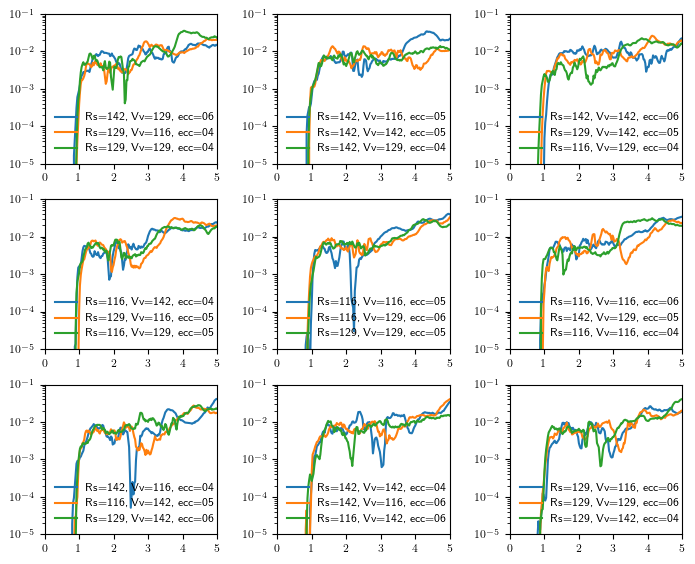

In [127]:
fig, axs = plt.subplots(3, 3, figsize=(textwidth, 0.8 * textwidth))

logFeH0 = 0
dlogFeH = 0.1
bins = np.arange(0, 8 + 0.1, 0.1)
i_FeH = 10

# Iterate over 3x3 panels
for i in range(3):
    for j in range(3):
        ax = axs[i][j]
        
        # Determine the range of indices for the current panel
        start_idx = (i * 3 + j) * 3
        end_idx = start_idx + 3
        
        # Fetch the corresponding 3 lowest bim_metric and their associated parameters
        panel_bim_metrics = bim_metric[start_idx:end_idx]
        panel_sim_params = ordered_sim[start_idx:end_idx]
        
        for bim, (Rs, Vv, ecc) in zip(panel_bim_metrics, panel_sim_params):
            # Access the simulation data
            dat = alldat[Rs][Vv][ecc]
            
            # Construct GMM and compute logFeH and logMgFe
            ax.plot(dat['Time'], dat['Mgas_inFeHbin'][:,i_FeH]/dat['galSFR'], 
                    label=f"Rs={Rs}, Vv={Vv}, ecc={ecc}")
        
        ax.set(xlim=(0, 5), yscale='log', ylim=(1e-5, 1e-1))#, ylim=(5e-2, 1e1))
        # ax.axhline(0.1, c='k', ls='dashed')
        ax.legend(fontsize=8, frameon=False)

fig.tight_layout()


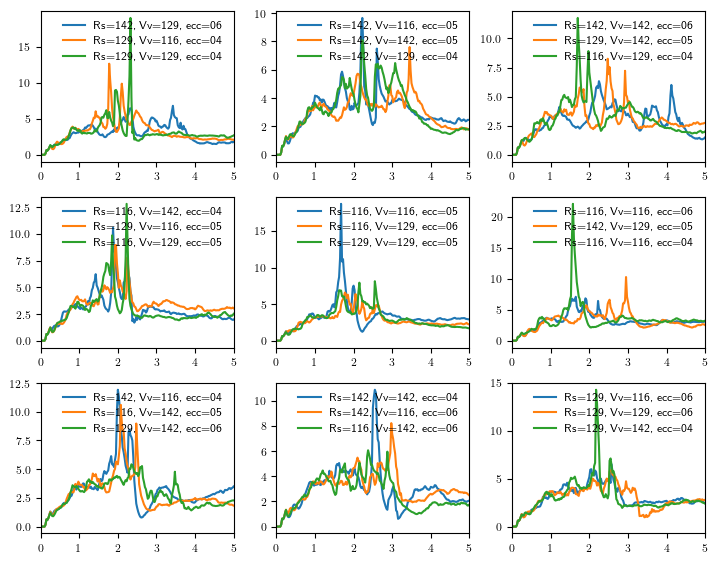

In [131]:
fig, axs = plt.subplots(3, 3, figsize=(textwidth, 0.8 * textwidth))

logFeH0 = 0
dlogFeH = 0.1
bins = np.arange(0, 8 + 0.1, 0.1)
i_FeH = 10

# Iterate over 3x3 panels
for i in range(3):
    for j in range(3):
        ax = axs[i][j]
        
        # Determine the range of indices for the current panel
        start_idx = (i * 3 + j) * 3
        end_idx = start_idx + 3
        
        # Fetch the corresponding 3 lowest bim_metric and their associated parameters
        panel_bim_metrics = bim_metric[start_idx:end_idx]
        panel_sim_params = ordered_sim[start_idx:end_idx]
        
        for bim, (Rs, Vv, ecc) in zip(panel_bim_metrics, panel_sim_params):
            # Access the simulation data
            dat = alldat[Rs][Vv][ecc]
            
            # Construct GMM and compute logFeH and logMgFe
            ax.plot(dat['Time'], dat['galSFR'], 
                    label=f"Rs={Rs}, Vv={Vv}, ecc={ecc}")
        
        ax.set(xlim=(0, 5))#, yscale='log')#, ylim=(1e-5, 1e-1))#, ylim=(5e-2, 1e1))
        # ax.axhline(0.1, c='k', ls='dashed')
        ax.legend(fontsize=8, frameon=False)

fig.tight_layout()
